<a href="https://colab.research.google.com/github/AntonioCCosta/DPG_PhysicsBehavior_2026/blob/main/notebooks/notebook_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physics of Behavior Tutorial II - Part 2

In this session, we will expand on the semi-analytic calculations of notebook_1, and learn the transfer operator dynamics directly from simulations of the particle in a double well.

Before we start, let's load the environment and the repository

In [1]:
# Environment setup
!pip install -q -r https://raw.githubusercontent.com/AntonioCCosta/DPG_PhysicsBehavior_2026/main/requirements.txt

In [2]:
import os

if not os.path.exists("DPG_PhysicsBehavior_2026"):
    !git clone https://github.com/AntonioCCosta/DPG_PhysicsBehavior_2026.git
else:
    %cd DPG_PhysicsBehavior_2026
    !git pull
    %cd ..

import sys, platform
print("Python:", sys.version)
print("Platform:", platform.platform())

/content/DPG_PhysicsBehavior_2026
Already up to date.
/content
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.113+-x86_64-with-glibc2.35


In [3]:
import h5py
import numpy as np
import numpy.ma as ma
sys.path.append('./DPG_PhysicsBehavior_2026/utils')
import operator_calculations as op_calc
import delay_embedding as embed
import partition_methods as cl
import coarse_graining as cgm
import matplotlib.pyplot as plt

## Stochastic dynamics on a 1d double well

In notebook_1, we directly used the analytical expression to solve the Fokker-Planck equation using a finite-difference approach. However, in most real world scenarios, the equations of motion are unavailable, and instead we only have access to a finite set of observations. Here, we will see how we can directly approximate the transfer operator and its eigenspectrum directly from observations.

Let's consider again overdamped Langevin dynamics on a potential landscape,

$$
\dot{x}(t) = -\partial_x V(x) + \sqrt{2 T_x}\,\eta(t),
\qquad \langle \eta(t)\eta(t') \rangle = \delta(t-t').
$$

Where the potential landscape is given by of a double well type:

$$
V(x) = \frac{x^4}{4} -\mu \frac{x^2}{2}
$$


## Estimating the transition matrix from data

The finite time operator $P_\tau$ estimated is effectively a transition probability matrix among state space regions, which can be estimated directly from time series observations. The simplest way to do this is to simply partition the domain and count transitions among state space regions. This is called the Ulam-Galerkin method.

Technically speaking, the Galerkin projection takes the infinite dimensional operator onto an $N\times N$ operator of finite rank by truncating an infinite dimensional set of basis functions at a finite $N$. Ulam's method uses characteristic functions as the basis for this projection,

$$
\zeta_i(x) = \begin{cases}
    1, & \text{for $x \in s_i$}\\
    0, & \text{otherwise}
    \end{cases}.
$$

We thus partition the space into $N$ connected sets with nonempty and disjoint interior that covers $M$: $M = \cup_{i=1}^N s_i$, and approximate the transfer operator as a Markov chain by counting transitions from $s_i$ to $s_j$ in a finite time $\tau$. Given T observations, a set of $N$ partitions, and a transition time $\tau$, we compute

$$
C_{ij}(\tau) = \sum_{t=0}^{T-\tau}\zeta_i(x(t))\zeta_j(x(t+\tau))
$$

The maximum likelihood estimator of the transition matrix is obtained by simply row normalizing the count matrix,

$$
P_{ij}(\tau) = \frac{C_{ij}(\tau)}{\sum_j C_{ij}(\tau)}.
$$

To partition the state-space into Voronoi cells, we will use the k-means algorithm to identify $N$ clusters that minimize the within cluster variances. Let's see how that works for our simulations.

In [44]:
from numba import jit,prange
@jit(nopython=True, parallel=True)
def simulate_dw(x0s,mu, Tx, dt, max_iters,downsampling):
    n_sims = len(x0s)
    sims = np.zeros((n_sims, int(max_iters/downsampling)))
    for ks in prange(n_sims):
        x0 = x0s[ks]
        x = x0
        for i in range(max_iters):
            new_x = x + (-x**3+mu*x) * dt + np.sqrt(2 * Tx) * np.random.normal(0, np.sqrt(dt))
            x = new_x
            if i%downsampling==0:
                sims[ks, int(i/downsampling)] = x
    return sims

Tx=3e-1 #temperature
T = 1000
dt=1e-3
max_iters=int(T/dt)
final_dt = 1e-1
downsampling = int(final_dt/dt)
n_sims = 500
x0s = np.random.uniform(-1,1,n_sims)
mu=1
sims = simulate_dw(x0s,mu, Tx, dt, max_iters,downsampling)

In [45]:
N=1000
#labels_all is an array with the partition that each point in the time series belongs to
#centers is the centroid of each k-means cluster
labels_all,centers = cl.kmeans_partition(np.hstack(sims).reshape(-1,1),N,batchsize=10000,return_centers=True)

To emulate the calculation from notebook_1, we take a delay 0.2s and estimate the transition matrix by counting. As you can see below, the implied timescales of the inferred transition matrix, $|\Lambda|_k^{-1} = -\tau/\log(\lambda_k(\tau))$ match the theoretical predictions obtained through Kramer's approximation (the match would be better with a larger $\mu/T_x$ and longer simulation times but this would take too long to compute in this tutorial, but try it yourself!)

In [46]:
delay=1
P_emp = op_calc.transition_matrix(labels_all,delay)
R = op_calc.get_reversible_transition_matrix(P_emp) #ensure reversibility
eigvals_emp,eigvecs_emp = op_calc.sorted_spectrum(R,k=5)
timp=-delay*final_dt/np.log(eigvals_emp[1].real)

print('estimated timescale: {:.4f}'.format(timp))

def kramers_rate(mu, Tx):
    # Well minimum
    x_m = np.sqrt(mu)
    # Barrier top
    x_s = 0.0

    V = lambda x,mu: x**4/4-mu*x**2/2

    # Second derivatives
    Vpp_m = 3 * x_m**2 - mu  # V''(x_m)
    Vpp_s = 3 * x_s**2 - mu  # V''(x_s)

    # Barrier height
    DeltaV = V(x_s, mu) - V(x_m, mu)

    # Kramers rate (overdamped, 1D)
    k = np.sqrt(abs(Vpp_s) * Vpp_m) / (2 * np.pi) * np.exp(-DeltaV / Tx)
    return k

print('analytical timescale: {:.4f}'.format(0.5/kramers_rate(mu,Tx)))

estimated timescale: 4.1796
analytical timescale: 5.1115


We can also compare this with the transition rates obtained from the data

In [40]:
def state_lifetime(states,tau):
    durations=[]
    for state in np.sort(np.unique(states.compressed())):
        gaps = states==state
        gaps_boundaries = np.where(np.abs(np.diff(np.concatenate([[False], gaps, [False]]))))[0].reshape(-1, 2)
        durations.append(np.hstack(np.diff(gaps_boundaries))*tau)
    return durations

delta=1e-3*np.sqrt(mu)
xs = np.hstack(sims)
states = np.zeros_like(xs)
states[xs >  delta] = +1
states[xs < -delta] = -1
states = np.ma.masked_equal(states, 0)
durs = np.hstack(state_lifetime(states,final_dt))

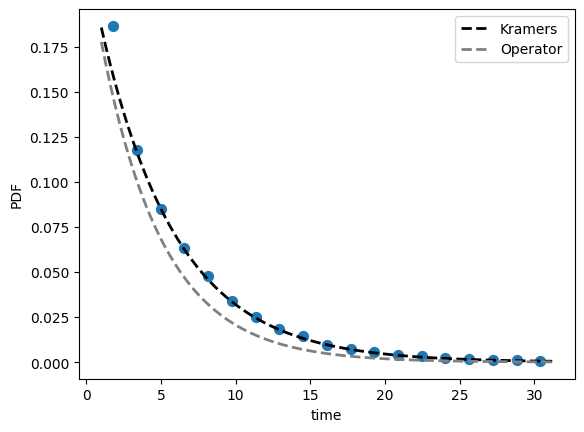

In [43]:
tmin=1
tmax=np.percentile(durs,99.9)
freqs,bin_edges = np.histogram(durs, bins=np.linspace(tmin,tmax,20), density=True)
centers_t = (bin_edges[1:]+bin_edges[:-1])/2
plt.scatter(centers_t,freqs,marker='o',s=50)
times = np.linspace(tmin,tmax,100)
_,b=np.polyfit(centers_t,np.log(freqs),1) #just to get the offset
rate = 2*kramers_rate(mu,Tx) #2x because it's only the time to the boundary
plt.plot(times,np.exp(b)*np.exp(-rate*times),c='k',lw=2,ls='--',label=r'Kramers')
rate = 1/timp
plt.plot(times,np.exp(b)*np.exp(-rate*times),c='gray',lw=2,ls='--',label=r'Operator')

# plt.yscale('log')
plt.ylabel('PDF')
plt.xlabel('time')
plt.legend()
plt.show()

Besides the slowest timescale, the inferred slow eigenvector $\phi_2$ should resemble the $\phi_2$ obtained from the semi-analytical operator in notebook_1 (up to a sign flip). Let's check

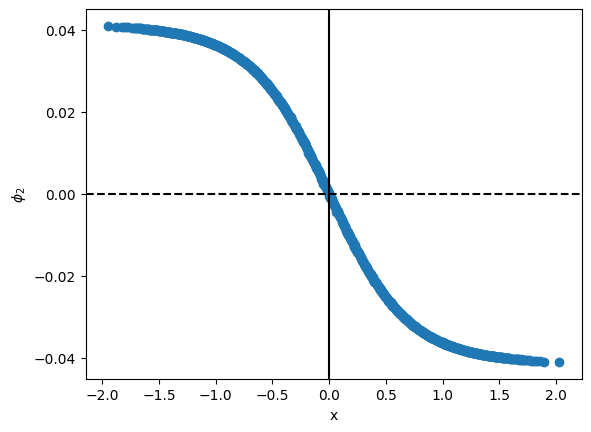

In [47]:
eigvecs_emp = eigvecs_emp.real
eigvecs_emp = eigvecs_emp/np.linalg.norm(eigvecs_emp,axis=0)
phi2_emp = eigvecs_emp[:,1]
sorted_indices = np.argsort(phi2_emp)
plt.scatter(centers[sorted_indices],phi2_emp[sorted_indices])
plt.ylabel(r'$\phi_2$')
plt.xlabel('x')
plt.axvline(0,c='k')
plt.axhline(0,c='k',ls='--')
plt.show()


Given $\phi_2$, we can now proceed as in notebook_1 and find the location of the energy barrier by estimating the coherence of metastable sets along $\phi_2$.

In [29]:
inv_measure_emp = op_calc.stationary_distribution(P_emp)
cr,rho_sets,ms,idx,km_labels = cgm.optimal_partition(phi2_emp,inv_measure_emp,P_emp,return_rho=True)

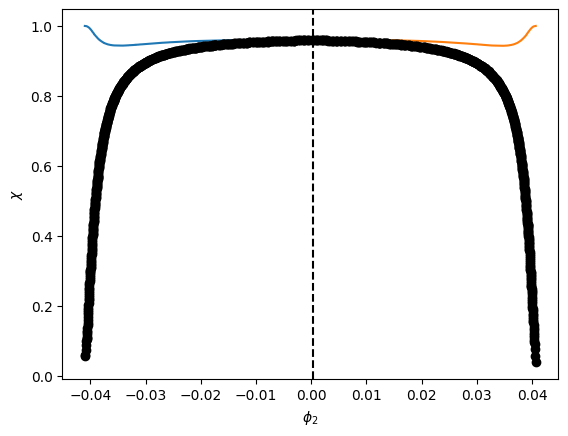

In [30]:
plt.plot(cr,rho_sets)
plt.plot(cr,np.min(rho_sets,axis=1),marker='o',c='k')
plt.axvline(cr[idx],c='k',ls='--')
plt.ylabel(r'$\chi$')
plt.xlabel(r'$\phi_2$')
plt.show()

# EXTRA

We can also then build a coarse-grained Markov model that capture only the transitions among the metastable states on long timescales. Since we coarse-grain in space, we should also select a larger transition time

In [31]:
label_traj=km_labels[labels_all]
delay=5
Pc = op_calc.transition_matrix(label_traj,delay)

In [33]:
from joblib import Parallel, delayed

def simulate(P,state0,iters):
    '''
    Monte Carlo simulation of the markov chain characterized by the matrix P
    state0: initial system
    iters: number of iterations of the simulation
    '''
    states = np.zeros(iters,dtype=int)
    states[0]=state0
    state=state0
    for k in range(1,iters):
        new_state = np.random.choice(np.arange(P.shape[1]),p=list(P[state,:]))
        state=new_state
        states[k]=state
    return states

n_sims=500
state0s = np.random.choice([0,1],n_sims)
n_iters=2000

sims_coarse = Parallel(n_jobs=-1)(delayed(simulate)(Pc.toarray(),state0,n_iters) for state0 in state0s)

In [34]:
all_durs = np.hstack([np.hstack(state_lifetime(ma.array(sim),final_dt*delay)) for sim in sims_coarse])

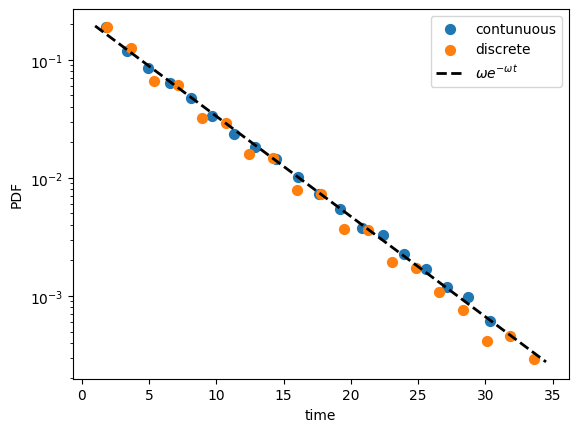

In [35]:
tmin=1
tmax=np.percentile(durs,99.9)
freqs,bin_edges = np.histogram(durs, bins=np.linspace(tmin,tmax,20), density=True)
centers_t = (bin_edges[1:]+bin_edges[:-1])/2
plt.scatter(centers_t,freqs,marker='o',s=50,label='contunuous')

tmax=np.percentile(all_durs,99.9)

freqs,bin_edges = np.histogram(all_durs, bins=np.linspace(tmin,tmax,20), density=True)
centers_t = (bin_edges[1:]+bin_edges[:-1])/2
plt.scatter(centers_t,freqs,marker='o',s=50,label='discrete')

times = np.linspace(tmin,tmax,100)
_,b=np.polyfit(centers_t,np.log(freqs),1) #just to get the offset
rate = 2*kramers_rate(mu,Tx) #2x because it's only the time to the boundary
plt.plot(times,np.exp(b)*np.exp(-rate*times),c='k',lw=2,ls='--',label=r'$\omega e^{-\omega t}$')
plt.yscale('log')
plt.ylabel('PDF')
plt.xlabel('time')
plt.legend()
plt.show()